<h1 align="center">🫁 Lungs Segmentation for refining Pneumonia Detection ⚕️</font></h1>

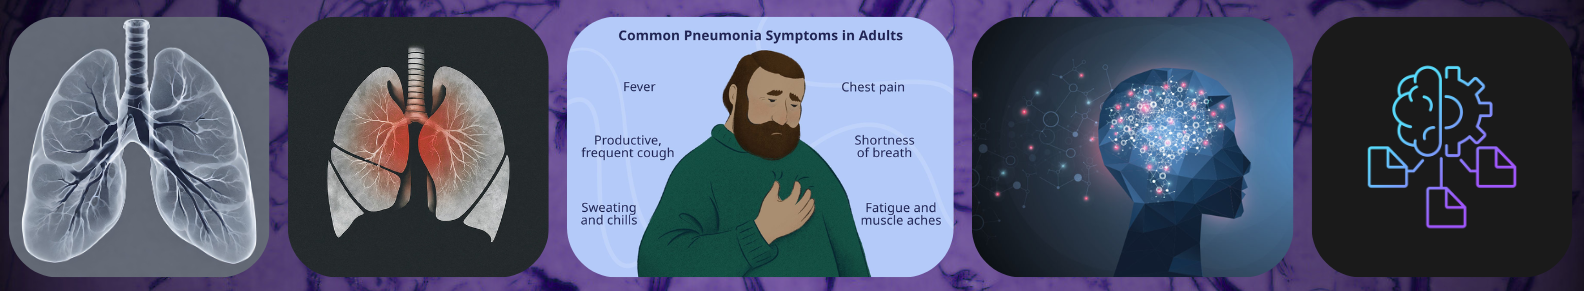

## Coding part starts from here 🔽

### Importing required Libraries

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Margin function to set a margin of 10% on the all four sides to remove Labels to avoid irrelevant things [ R, L, Name ]

In [61]:
def margin(img, margin_percent=10):
  h, w = img.shape
  margin_x = int(w * margin_percent / 100)
  margin_y = int(h * margin_percent / 100)
  cropped = img[margin_y:h-margin_y, margin_x:w-margin_x]
  return cropped

### KMeans Clustering used in image segmentation to partition xray_images into regions based on pixel similarities 

In [62]:
def process(img):
  flat_img = img.flatten().reshape(-1, 1)
  kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
  labels = kmeans.fit_predict(flat_img)
  centers = kmeans.cluster_centers_
  if np.mean(centers[1]) > np.mean(centers[0]):
    labels = 1 - labels
  clustered = np.reshape(labels, img.shape)
  clustered_binary = np.uint8(clustered * 255)
  return clustered_binary

### Filter Largest Contour in Image

* Thresholding: Convert the input image to a binary image using a threshold.
* Contour Detection: Find contours in the binary image.
* Contour Filtering: Select the largest contour based on area.
* Result Generation: Create a new image with the selected contour filled in.
* Return: Return the filtered image and the list of largest contours found.

In [63]:
def segment_and_filter(clustered_img):
  ret, thresh = cv2.threshold(clustered_img, 0, 255, cv2.THRESH_BINARY)
  if cv2.__version__[0] > '3':
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  else:
    _, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  max_area = 0
  largest_contours = []
  for contour in contours:
    area = cv2.contourArea(contour)
    if area > max_area:
      max_area = area
      largest_contours.append(contour)
  
  result = np.zeros_like(clustered_img)
  cv2.drawContours(result, largest_contours, -1, 255, thickness=cv2.FILLED)
  return result, largest_contours

### Enhanced Image processing

* Read and convert the input image to grayscale.
* Crop the margins of the image.
* Process the cropped image (e.g., perform clustering).
* Segment and filter the processed image to get desired regions.
* Join the filtered region with its horizontally flipped version.

In [64]:
def process_image(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  cropped_img = margin(img)
  clustered_img = process(cropped_img)
  filtered_result, largest_contours = segment_and_filter(clustered_img)
  
  joined_image = cv2.hconcat([filtered_result[:, :filtered_result.shape[1] // 2],  
                  cv2.flip(filtered_result[:, :filtered_result.shape[1] // 2], 1)])
  
  return joined_image

def calculate_trapezium_area(top_width, bottom_width, height):
  area = 0.5 * (top_width + bottom_width) * height
  return area

### Define Trapezium & its Area

In [65]:
def calculate_trapezium_area(top_width, bottom_width, height):
  area = 0.5 * (top_width + bottom_width) * height
  return area

### Joining and fitting Trapezium to show the the total lungs area

* Convert the input image to color (RGB) format.
* Threshold the image to create a binary image.
* Find contours in the binary image.
* Sort the contours by area and select the two largest contours.
* Create a bounding rectangle around the combined two contours.
* Define the vertices of a trapezium based on the bounding rectangle.
* Draw the trapezium on the color image.
* Calculate and print the area of the trapezium.
* Return the color image with the plotted trapezium.

In [66]:
def detect_and_plot_trapezium(joined_image):
  color_image = cv2.cvtColor(joined_image, cv2.COLOR_GRAY2BGR)
  _, binary_image = cv2.threshold(joined_image, 1, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
  combined_rect = cv2.boundingRect(np.concatenate(contours))
  combined_rect = (combined_rect[0] - 20, combined_rect[1] - 20, combined_rect[2] + 40, combined_rect[3] + 40)

  combined_trapezium_pts = [[(combined_rect[0], combined_rect[1] + combined_rect[3])],
                [(combined_rect[0] + combined_rect[2], combined_rect[1] + combined_rect[3])],
                [(combined_rect[0] + combined_rect[2] * 0.75, combined_rect[1])],
                [(combined_rect[0] + combined_rect[2] * 0.25, combined_rect[1])]]

  cv2.polylines(color_image, [np.array(combined_trapezium_pts, np.int32)], isClosed=True, color=(0, 0, 255), thickness=10)

  top_width = combined_rect[2] * 0.5
  bottom_width = combined_rect[2]
  height = combined_rect[3]
  area = calculate_trapezium_area(top_width, bottom_width, height)
  print("Area of the combined trapezium:", area)

  return color_image

### Image Path

In [67]:
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0013-0001.jpeg"

### Displaying Original and Processed Images with Trapezium plotting

Area of the combined trapezium: 2417167.5


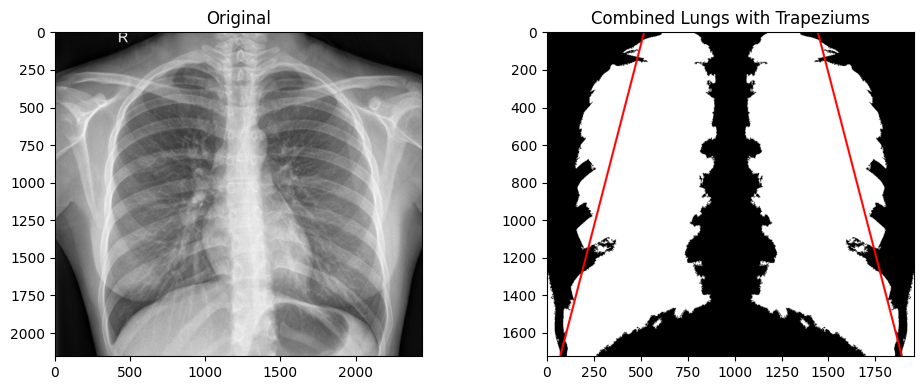

In [68]:
og_image = cv2.imread(image_path)
result_image = process_image(image_path)
result_image_with_trapezium = detect_and_plot_trapezium(result_image)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(cv2.cvtColor(og_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[0].axis('on')

axs[1].imshow(cv2.cvtColor(result_image_with_trapezium, cv2.COLOR_BGR2RGB))
axs[1].set_title('Combined Lungs with Trapeziums')
axs[1].axis('on')

plt.tight_layout()
plt.show()

# Achieved 9% increase in accuracy running a Pneumonia Model on same Chest Xray Dataset

## Without Segmentation
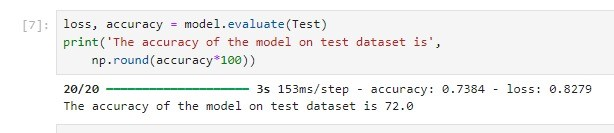

## With Segmentation
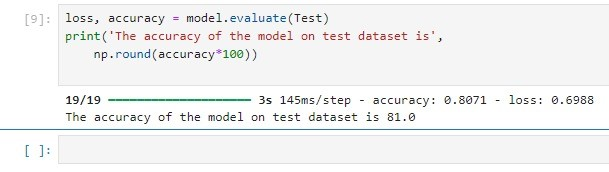

<h1 align="center"> THE END </font></h1>

#### Batch Processing with Multi-threading

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import concurrent.futures

def margin(img, margin_percent=10):
  h, w = img.shape
  margin_x = int(w * margin_percent / 100)
  margin_y = int(h * margin_percent / 100)
  cropped = img[margin_y:h-margin_y, margin_x:w-margin_x]
  return cropped

def process(img):
  flat_img = img.flatten().reshape(-1, 1)
  kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
  labels = kmeans.fit_predict(flat_img)
  centers = kmeans.cluster_centers_
  if np.mean(centers[1]) > np.mean(centers[0]):
    labels = 1 - labels
  clustered = np.reshape(labels, img.shape)
  clustered_binary = np.uint8(clustered * 255)
  return clustered_binary

def segment_and_filter(clustered_img):
  ret, thresh = cv2.threshold(clustered_img, 0, 255, cv2.THRESH_BINARY)
  if cv2.__version__[0] > '3':
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  else:
    _, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  max_area = 0
  largest_contours = []
  for contour in contours:
    area = cv2.contourArea(contour)
    if area > max_area:
      max_area = area
      largest_contours.append(contour)
  
  result = np.zeros_like(clustered_img)
  cv2.drawContours(result, largest_contours, -1, 255, thickness=cv2.FILLED)
  return result, largest_contours

def process_image(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  cropped_img = margin(img)
  clustered_img = process(cropped_img)
  filtered_result, largest_contours = segment_and_filter(clustered_img)
  
  joined_image = cv2.hconcat([filtered_result[:, :filtered_result.shape[1] // 2],  
                  cv2.flip(filtered_result[:, :filtered_result.shape[1] // 2], 1)])
  
  return joined_image

def calculate_trapezium_area(top_width, bottom_width, height):
  area = 0.5 * (top_width + bottom_width) * height
  return area

def calculate_trapezium_area(top_width, bottom_width, height):
  area = 0.5 * (top_width + bottom_width) * height
  return area

def detect_and_plot_trapezium(joined_image):
  color_image = cv2.cvtColor(joined_image, cv2.COLOR_GRAY2BGR)
  _, binary_image = cv2.threshold(joined_image, 1, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
  combined_rect = cv2.boundingRect(np.concatenate(contours))
  combined_rect = (combined_rect[0] - 20, combined_rect[1] - 20, combined_rect[2] + 40, combined_rect[3] + 40)

  combined_trapezium_pts = [[(combined_rect[0], combined_rect[1] + combined_rect[3])],
                [(combined_rect[0] + combined_rect[2], combined_rect[1] + combined_rect[3])],
                [(combined_rect[0] + combined_rect[2] * 0.75, combined_rect[1])],
                [(combined_rect[0] + combined_rect[2] * 0.25, combined_rect[1])]]

  cv2.polylines(color_image, [np.array(combined_trapezium_pts, np.int32)], isClosed=True, color=(0, 0, 255), thickness=10)

  top_width = combined_rect[2] * 0.5
  bottom_width = combined_rect[2]
  height = combined_rect[3]
  area = calculate_trapezium_area(top_width, bottom_width, height)
  print("Area of the combined trapezium:", area)

  return color_image

# Sample on a single folder
input_folder = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/"
output_folder = "/kaggle/working/"

image_files = [file for file in os.listdir(input_folder) if file.endswith(".jpeg")]

def process_and_save_image(image_file):
    image_path = os.path.join(input_folder, image_file)
    result_image = process_image(image_path)
    result_image_with_trapezium = detect_and_plot_trapezium(result_image)
    
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, result_image_with_trapezium)

with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(process_and_save_image, image_files)